Dimensão física da imagem DICOM / distância entre pixels para restringir o tamanho máximo dos objetos.

In [1]:
import pydicom

# Load the DICOM image
#ds = pydicom.dcmread("C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/MRI 20230210/MR.1.2.752.24.3.3447912607.4062367.27503536.10147659820.1676389698.dcm")
#Para CT:
ds = pydicom.dcmread("C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT 20230210/CT.1.2.840.113619.2.278.3.2831159384.586.1676011671.578.1.dcm")

# Get the pixel dimensions
rows = ds.Rows
columns = ds.Columns

print("Rows: ", rows)
print("Columns: ", columns)

Rows:  512
Columns:  512


In [2]:
pixel_spacing_row = ds.PixelSpacing[0]
pixel_spacing_col = ds.PixelSpacing[1]

print("Pixel Spacing (Row): ", pixel_spacing_row)
print("Pixel Spacing (Column): ", pixel_spacing_col)

Pixel Spacing (Row):  0.976562
Pixel Spacing (Column):  0.976562


Blob detection in Python

In [3]:
from tools import CTBodyDetector, RandoHolesDetector, RandoHolesDetectorCV
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ct_folder_path = r"C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT 20230210"

index2 = 184

## Read folder with series
ct_reader = sitk.ImageSeriesReader()
ct_file_names = ct_reader.GetGDCMSeriesFileNames(ct_folder_path)
ct_reader.SetFileNames(ct_file_names)
ct_reader.MetaDataDictionaryArrayUpdateOn()
ct_volume = ct_reader.Execute()
img_slice = ct_volume[:,:,index2]


## Get info
window_center = int(ct_reader.GetMetaData(index2, '0028|1050'))
window_width = int(ct_reader.GetMetaData(index2, '0028|1051'))
img_height = img_slice.GetHeight()
img_width = img_slice.GetWidth()
pixel_spacing = img_slice.GetSpacing()
origin = img_slice.GetOrigin()

    ## Intensity Window (For viewing purposes only)
img_slice_view_n = sitk.IntensityWindowing(img_slice, window_center - window_width, window_center + window_width)

    ## Remove the table from image (if hardtop)
    #table_height = ct_reader.GetMetaData(img_idx, '0018|1130')
table_height = float(ct_reader.GetMetaData(index2, '0018|1130').strip())
table_height_ct = table_height
    


The cv2.findContours() function in the OpenCV library is used to detect contours (or outlines) in an image. It takes several arguments to specify the input image, contour retrieval mode, and contour approximation method. Here are the main arguments:

image: This is the input image on which contours are to be detected. It should be a grayscale or binary image (thresholded) where contours are represented by white pixels on a black background.

mode: This argument specifies the retrieval mode for contours. It determines the hierarchy of the contours that are retrieved. It can have one of the following values:

    cv2.RETR_EXTERNAL: Retrieves only the external (outer) contours.
    cv2.RETR_LIST: Retrieves all contours without any hierarchical structure.
    cv2.RETR_CCOMP: Retrieves all contours in a two-level hierarchy, where the first level contains external contours and the second level contains contours inside holes of external contours.
    cv2.RETR_TREE: Retrieves all contours in a full hierarchy, representing nested contours.
    method: This argument specifies the contour approximation method. It determines how the contour points are stored and approximated. It can have one of the following values:

        cv2.CHAIN_APPROX_NONE: Stores all contour points without any approximation.
        cv2.CHAIN_APPROX_SIMPLE: Stores only the end points of the contour segments, which reduces the number of points and provides a more compact representation of the contour.
        cv2.CHAIN_APPROX_TC89_L1 or cv2.CHAIN_APPROX_TC89_KCOS: Applies one of the flavors of the Teh-Chin chain approximation algorithm, which provides smoother contours compared to cv2.CHAIN_APPROX_SIMPLE.
        contours, hierarchy: These are the output parameters that store the detected contours and their hierarchy, respectively. contours is a Python list of contours, where each contour is represented as a numpy array of shape (N, 1, 2) containing N points. hierarchy is an optional output parameter that represents the hierarchical structure of the contours, depending on the retrieval mode specified.

Additional optional arguments can be used to specify the contour retrieval mode and contour approximation method. For example, offset can be used to specify an optional offset to be added to the coordinates of the detected contours.

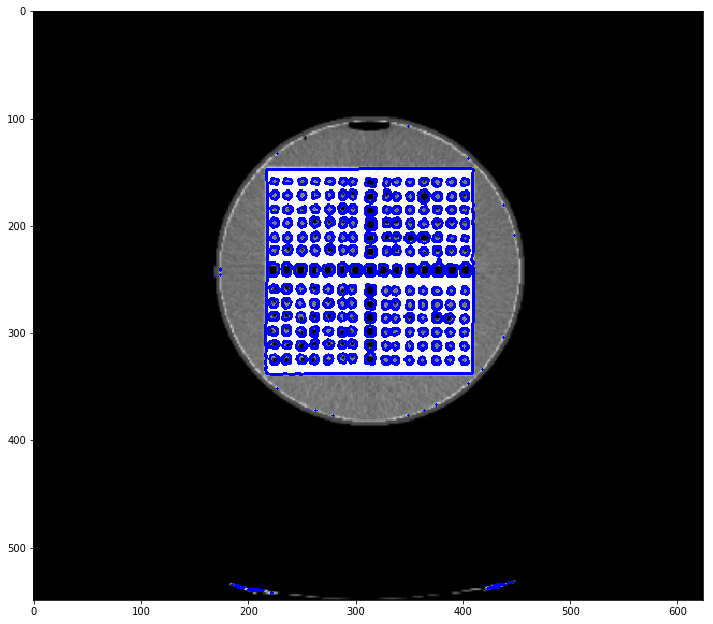

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#import image
img = cv2.imread("C:/Users/bernc/Downloads/converted.jpg", 0)

#Thresh
ret, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
#Original: ret, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)

#Finding the contours in the image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS) 
#original: cv2.CHAIN_APPROX_SIMPLE no 2º parâmetro

#print(len(a))

#Convert img to RGB and draw contour
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#cv2.drawContours(img, contours, 0, (0,0,255), 2)
cv2.drawContours(img, contours, -1, (0,0,255), 2)


#save output img
#cv2.imwrite('output_img.png', img)

# display it
plt.figure(figsize=(12,12))
imgplot = plt.imshow(img)

#cv2.imshow("IMAGE", img)
#cv2.waitKey(0)

**Hierarchy information:**


In the context of contour detection using the cv2.findContours() function in OpenCV, the "hierarchy" refers to the relationship between contours found in an image. The hierarchy parameter returned by the cv2.findContours() function is a numpy array that represents the hierarchical structure of contours.

The hierarchy information is used to represent the nesting or hierarchical relationship between contours in an image. It contains information about the parent contour, the first child contour, the previous contour, and the next contour for each contour in the image.

The hierarchy array has the shape (1, N, 4), where N is the total number of contours found in the image. Each row in the hierarchy array corresponds to a contour and contains four integer values:

    [next, previous, first child, parent], where:

    next: Index of the next contour at the same hierarchical level.
    previous: Index of the previous contour at the same hierarchical level.
    first child: Index of the first child contour.
    parent: Index of the parent contour.
    
    
The values of -1 in the hierarchy array indicate that a particular hierarchy relationship does not exist for a contour. For example, if the next value is -1, it means that the current contour does not have any next contour at the same hierarchical level.

The hierarchy information can be useful in cases where you need to traverse or analyze contours based on their nesting or hierarchical relationship, such as identifying inner contours within outer contours, or determining the parent-child relationship between contours.





**Threshold information:**

The cv2.threshold() function in OpenCV is used to perform image thresholding, which is a common technique in image processing to create binary images from grayscale or color images. The function takes the following arguments:

    retval, threshold = cv2.threshold(src, thresh, maxval, type[, dst])
where:

    src: Input image, which can be a grayscale image or a single channel image (e.g., one channel of a color image).
    thresh: Threshold value, which is used to classify the pixels of the input image into two categories: pixels below the threshold value and pixels above the threshold value.
    maxval: Maximum value that can be assigned to pixels that are above the threshold value. This is often set to 255 for binary images.
    type: Thresholding type, which specifies how the thresholding operation should be performed. It is represented by an integer value and can be one of the following:
        cv2.THRESH_BINARY: Binary thresholding, where pixels below the threshold value are set to 0, and pixels above the threshold value are set to maxval.
        cv2.THRESH_BINARY_INV: Inverse binary thresholding, where pixels below the threshold value are set to maxval, and pixels above the threshold value are set to 0.
        cv2.THRESH_TRUNC: Truncated thresholding, where pixels below the threshold value are set to the threshold value, and pixels above the threshold value are unchanged.
        cv2.THRESH_TOZERO: Threshold to zero, where pixels below the threshold value are set to 0, and pixels above the threshold value are unchanged.
        cv2.THRESH_TOZERO_INV: Inverse threshold to zero, where pixels below the threshold value are unchanged, and pixels above the threshold value are set to 0.
    dst: Optional output image, which is the same size and type as the input src image. If not specified, a new image will be created.
    
The cv2.threshold() function returns two values:

    retval: The threshold value used in the thresholding operation, which is the same as the input thresh value.
    threshold: The output binary image after thresholding.

Agora filitrar, de modo a retirar blobs com área muito pequena ou longe do centro (table) e para ficar só com as circulares

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#import image
#img = cv2.imread("C:/Users/bernc/Downloads/converted.jpg", 0)
img = cv2.imread("C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT_JPG/5_140.png", 0)


#Thresh
ret, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
#Original: ret, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)

#Finding the contours in the image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS) 
#original: cv2.CHAIN_APPROX_SIMPLE no 2º parâmetro
print('NÚMER DE CONTOURS antes dos filtros: ', len(contours))

# Get the center of the image
image_height, image_width = img.shape[:2]
center_x = image_width // 2
center_y = image_height // 2

# Define the minimum contour area and maximum distance from center
min_contour_area = 10  # adjust as needed #OG: 10
max_contour_area = 70  # adjust as needed #OG: 70
max_distance_from_center = 500  # adjust as needed; para a mesa não aparecer #OG: 500
#intensity_threshold = 160  # adjust as needed; para filtrar os que têm ar

# Define the circularity threshold
circularity_threshold = 0.7  # adjust as needed #OG: 0.7

# Filter contours based on size and distance from center
filtered_contours = []


intensity_array = [] #Para fazer com que o threshold de intensidade interno seja a média das intensidades
#Todos os inserts cuja média de intensidades dos pixels internos seja inferior à média têm demasiado ar
#Podia usar critério mais relaxado
for contour in contours:
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], 0, 255, -1)
    mean_intensity = cv2.mean(img, mask=mask)[0]
    intensity_array.append(mean_intensity)
#print(intensity_array)
#intensity_threshold = np.mean(intensity_array)
##Agora, implemento threshold que é 10% abaixo da média da imagem
intensity_threshold = np.mean(intensity_array) - (np.mean(intensity_array) * 0.1)

for contour in contours:
    # Calculate the contour area
    contour_area = cv2.contourArea(contour)
    # Calculate the area and perimeter of the contour
    perimeter = cv2.arcLength(contour, True)
    
    # Calculate the circularity of the contour
    circularity = 4 * np.pi * (contour_area / (perimeter ** 2-0.01)) #+0.01 para não dividir por zero
    
    if contour_area >= min_contour_area and contour_area <= max_contour_area:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        centroid_x = int(M["m10"] / M["m00"])
        centroid_y = int(M["m01"] / M["m00"])
        
        # Calculate the distance from the centroid to the center of the image
        distance_from_center = np.sqrt((centroid_x - center_x) ** 2 + (centroid_y - center_y) ** 2)
        
        # Filter contours based on distance from center
        if distance_from_center <= max_distance_from_center:
            # Filter contours based on circularity
            if circularity >= circularity_threshold:
                #filtered_contours.append(contour)
                mask = np.zeros(img.shape, dtype=np.uint8)
                cv2.drawContours(mask, [contour], 0, 255, -1)
                mean_intensity = cv2.mean(img, mask=mask)[0]
                #print(mean_intensity)
                if mean_intensity > intensity_threshold:
                    filtered_contours.append(contour)

    

print('NÚMER DE CONTOURS depois dos filtros: ', len(filtered_contours))
# Draw filtered contours on the original image
image_with_filtered_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_with_filtered_contours, filtered_contours, -1, (0, 255, 0), 2)


# Display the original image with filtered contours
##cv2.imshow('Image with Filtered Contours', image_with_filtered_contours)
##cv2.waitKey(0)
##cv2.destroyAllWindows()


#save output img
##cv2.imwrite('output_img.png', img)

# display it
plt.figure(figsize=(12,12))
imgplot = plt.imshow(image_with_filtered_contours)


NÚMER DE CONTOURS antes dos filtros:  0


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
#import dicom2jpg
#dicom_dir = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT 20230210"
#export_location = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT_jpg_transf"

## convert all DICOM files in dicom_dir folder to png format
#dicom2jpg.dicom2png(dicom_dir)  

Agora para todas as slices, apresentando as 6 com mais contours:

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the folder path containing the images
folder_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT_JPG/"

# Define the number of slices to display
num_slices_to_display = 6

# Initialize a dictionary to store the number of contours for each slice
contour_counts = {}

# Loop through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):  # assuming all images are PNG files, adjust as needed
        # Load the image
        img = cv2.imread(os.path.join(folder_path, filename), 0)
        
        # Apply the contour detection process
        ret, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
        
        # Filter contours based on size, circularity, and intensity
        filtered_contours = []
        intensity_array = []
        intensity_threshold = np.mean(cv2.mean(img)[0]) - (np.mean(cv2.mean(img)[0]) * 0.1)
        circularity_threshold = 0.7
        for contour in contours:
            contour_area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * (contour_area / (perimeter ** 2 - 0.01))
            if contour_area >= 10 and contour_area <= 70 and circularity >= circularity_threshold:
                mask = np.zeros(img.shape, dtype=np.uint8)
                cv2.drawContours(mask, [contour], 0, 255, -1)
                mean_intensity = cv2.mean(img, mask=mask)[0]
                if mean_intensity > intensity_threshold:
                    filtered_contours.append(contour)
        contour_counts[filename] = len(filtered_contours)

# Sort the slices based on the number of contours
sorted_slices = sorted(contour_counts.items(), key=lambda x: x[1], reverse=True)

# Display the top 6 slices with the most contours in a 3x2 subplot
fig, axes = plt.subplots(3, 2, figsize=(24, 24))
for i in range(num_slices_to_display):
    filename, num_contours = sorted_slices[i]
    img = cv2.imread(os.path.join(folder_path, filename), 0)
    image_with_filtered_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    num_filtered_contours = 0 # Variable to keep track of the number of filtered contours
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * (contour_area / (perimeter ** 2 - 0.01))
        if contour_area >= 2 and contour_area <= 70 and circularity >= circularity_threshold:
            mask = np.zeros(img.shape, dtype=np.uint8)
            cv2.drawContours(mask, [contour], 0, 255, -1)
            mean_intensity = cv2.mean(img, mask=mask)[0]
            if mean_intensity > intensity_threshold:
                cv2.drawContours(image_with_filtered_contours, [contour], -1, (0, 255, 0), 2)
                num_filtered_contours += 1
    row_idx = i // 2
    col_idx = i % 2
    axes[row_idx, col_idx].imshow(image_with_filtered_contours)
    axes[row_idx, col_idx].set_title(f"Slice {filename} | Num Contours: {num_contours} | Num Filtered Contours: {num_filtered_contours}")
    axes[row_idx, col_idx].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define folder path
folder_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT_JPG/" 

indx=0
slices_over_10_points = []
no_slices_over_10_points = 0
# Loop over all files in the folder
for file_name in os.listdir(folder_path):
    indx+=1
    if file_name.endswith(".jpg") or file_name.endswith(".png"):  # Update with image file extensions
        # Read image
        image_path = os.path.join(folder_path, file_name)
        img = cv2.imread(image_path, 0)


        #Thresh
        ret, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
        #Original: ret, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)

        #Finding the contours in the image
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS) 
        #original: cv2.CHAIN_APPROX_SIMPLE no 2º parâmetro
        #print('NÚMER DE CONTOURS antes dos filtros: ', len(contours))

        # Get the center of the image
        image_height, image_width = img.shape[:2]
        center_x = image_width // 2
        center_y = image_height // 2

        # Define the minimum contour area and maximum distance from center
        min_contour_area = 10  # adjust as needed #OG: 10
        max_contour_area = 70  # adjust as needed #OG: 70
        max_distance_from_center = 150  # adjust as needed; para a mesa não aparecer #OG: 500
        #intensity_threshold = 160  # adjust as needed; para filtrar os que têm ar

        # Define the circularity threshold
        circularity_threshold = 0.7  # adjust as needed #OG: 0.7

        # Filter contours based on size and distance from center
        filtered_contours = []


        intensity_array = [] #Para fazer com que o threshold de intensidade interno seja a média das intensidades
        #Todos os inserts cuja média de intensidades dos pixels internos seja inferior à média têm demasiado ar
        #Podia usar critério mais relaxado
        for contour in contours:
            mask = np.zeros(img.shape, dtype=np.uint8)
            cv2.drawContours(mask, [contour], 0, 255, -1)
            mean_intensity = cv2.mean(img, mask=mask)[0]
            intensity_array.append(mean_intensity)
        #print(intensity_array)
        #intensity_threshold = np.mean(intensity_array)
        ##Agora, implemento threshold que é 10% abaixo da média da imagem
        intensity_threshold = np.mean(intensity_array) - (np.mean(intensity_array) * 0.1)

        for contour in contours:
            # Calculate the contour area
            contour_area = cv2.contourArea(contour)
            # Calculate the area and perimeter of the contour
            perimeter = cv2.arcLength(contour, True)

            # Calculate the circularity of the contour
            circularity = 4 * np.pi * (contour_area / (perimeter ** 2-0.01)) #+0.01 para não dividir por zero

            if contour_area >= min_contour_area and contour_area <= max_contour_area:
                # Calculate the centroid of the contour
                M = cv2.moments(contour)
                centroid_x = int(M["m10"] / M["m00"])
                centroid_y = int(M["m01"] / M["m00"])

                # Calculate the distance from the centroid to the center of the image
                distance_from_center = np.sqrt((centroid_x - center_x) ** 2 + (centroid_y - center_y) ** 2)

                # Filter contours based on distance from center
                if distance_from_center <= max_distance_from_center:
                    # Filter contours based on circularity
                    if circularity >= circularity_threshold:
                        #filtered_contours.append(contour)
                        mask = np.zeros(img.shape, dtype=np.uint8)
                        cv2.drawContours(mask, [contour], 0, 255, -1)
                        mean_intensity = cv2.mean(img, mask=mask)[0]
                        #print(mean_intensity)
                        if mean_intensity > intensity_threshold:
                            filtered_contours.append(contour)



        #print('NÚMER DE CONTOURS depois dos filtros: ', len(filtered_contours))
        # Draw filtered contours on the original image
        image_with_filtered_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(image_with_filtered_contours, filtered_contours, -1, (0, 255, 0), 2)


        # Display the original image with filtered contours
        ##cv2.imshow('Image with Filtered Contours', image_with_filtered_contours)
        ##cv2.waitKey(0)
        ##cv2.destroyAllWindows()


        #save output img
        ##cv2.imwrite('output_img.png', img)

        # display it
        if len(filtered_contours) > 9:
            slices_over_10_points.append(indx)
            no_slices_over_10_points += 1
            if no_slices_over_10_points%5 == 0: #so not all are shown, but only every 5 slices
                plt.figure(figsize=(9,9))
                imgplot = plt.imshow(image_with_filtered_contours)
                plt.title("Slice Number: {} | Number of Filtered Contours: {}".format(indx, len(filtered_contours)))
                plt.show()
print("There are {} slices with 10 or more detected inserts | Slice numbers: {}".format(no_slices_over_10_points, slices_over_10_points))

Old code version:

In [ ]:
import cv2
import numpy as np
import os

min_contour_area = 1  # adjust as needed #OG: 10
max_contour_area = 70  # adjust as needed #OG: 70
max_distance_from_center = 500  # adjust as needed; para a mesa não aparecer  #OG: 500
#intensity_threshold = 50  # adjust as needed; para filtrar os que têm ar


# Define the circularity threshold
circularity_threshold = 0.5 # adjust as needed  #OG: 0.7

# Define the folder path containing the images
folder_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT_JPG"

# Get a list of all the image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

# Keep track of the number of contours for each image
contour_counts = {}

# Loop through each image file
for image_file in image_files:
    #print(image_file)
    # Load the image
    img = cv2.imread(os.path.join(folder_path, image_file), 0)
    
    ret, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
    #Finding the contours in the image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS) 
    #original: cv2.CHAIN_APPROX_SIMPLE no 2º parâmetro


    # Get the center of the image
    image_height, image_width = img.shape[:2]
    center_x = image_width // 2
    center_y = image_height // 2
    # Filter contours based on size and distance from center
    filtered_contours = []


    intensity_array = [] #Para fazer com que o threshold de intensidade interno seja a média das intensidades
    #Todos os inserts cuja média de intensidades dos pixels internos seja inferior à média têm demasiado ar
    #Podia usar critério mais relaxado, como np.mean(intensity_array) - 10 no fim
    for contour in contours:
        mask = np.zeros(img.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], 0, 255, -1)
        mean_intensity = cv2.mean(img, mask=mask)[0]
        intensity_array.append(mean_intensity)
    #print(intensity_array)
    intensity_threshold =  np.mean(intensity_array) - (np.mean(intensity_array) * 0.1) #OG:   np.mean(intensity_array) - (np.mean(intensity_array) * 0.1)

    for contour in contours:
        # Calculate the contour area
        contour_area = cv2.contourArea(contour)
        # Calculate the area and perimeter of the contour
        perimeter = cv2.arcLength(contour, True)

        # Calculate the circularity of the contour
        circularity = 4 * np.pi * (contour_area / (perimeter ** 2-0.01)) #+0.01 para não dividir por zero

        if contour_area >= min_contour_area and contour_area <= max_contour_area:
            # Calculate the centroid of the contour
            M = cv2.moments(contour)
            centroid_x = int(M["m10"] / M["m00"])
            centroid_y = int(M["m01"] / M["m00"])

            # Calculate the distance from the centroid to the center of the image
            distance_from_center = np.sqrt((centroid_x - center_x) ** 2 + (centroid_y - center_y) ** 2)

            # Filter contours based on distance from center
            if distance_from_center <= max_distance_from_center:
                # Filter contours based on circularity
                if circularity >= circularity_threshold:
                    #filtered_contours.append(contour)
                    mask = np.zeros(img.shape, dtype=np.uint8)
                    cv2.drawContours(mask, [contour], 0, 255, -1)
                    mean_intensity = cv2.mean(img, mask=mask)[0]
                    #print(mean_intensity)
                    if mean_intensity > intensity_threshold:
                        filtered_contours.append(contour)


    # Get the number of contours for the current image
    contour_count = len(filtered_contours)
    if contour_count >= 50:
        print(contour_count)

    # Store the contour count in the dictionary with the image file name as the key
    contour_counts[image_file] = contour_count

# Sort the image file names based on contour count in descending order
sorted_image_files = sorted(contour_counts.keys(), key=lambda x: contour_counts[x], reverse=True)

# Get the top 6 image file names with the most number of contours
top_6_image_files = sorted_image_files[:6]

# Print the top 6 image file names with their respective contour counts
for i, image_file in enumerate(top_6_image_files):
    print("Image file #{}: {} | Contour count: {}".format(i+1, image_file, contour_counts[image_file]))
    
# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(24, 24))
axs = axs.ravel()

# Loop through the top 6 image files
for i, image_file in enumerate(top_6_image_files):
    # Load the image
    img = cv2.imread(os.path.join(folder_path, image_file))

    # Load the image
    img = cv2.imread(os.path.join(folder_path, image_file), 0)

    #Finding the contours in the image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS) 
    #original: cv2.CHAIN_APPROX_SIMPLE no 2º parâmetro


    # Get the center of the image
    image_height, image_width = img.shape[:2]
    center_x = image_width // 2
    center_y = image_height // 2
    # Filter contours based on size and distance from center
    filtered_contours = []

    for contour in contours:
        # Calculate the contour area
        contour_area = cv2.contourArea(contour)
        # Calculate the area and perimeter of the contour
        perimeter = cv2.arcLength(contour, True)

        # Calculate the circularity of the contour
        circularity = 4 * np.pi * (contour_area / (perimeter ** 2-0.01)) #+0.01 para não dividir por zero

        if contour_area >= min_contour_area and contour_area <= max_contour_area:
            # Calculate the centroid of the contour
            M = cv2.moments(contour)
            centroid_x = int(M["m10"] / M["m00"])
            centroid_y = int(M["m01"] / M["m00"])

            # Calculate the distance from the centroid to the center of the image
            distance_from_center = np.sqrt((centroid_x - center_x) ** 2 + (centroid_y - center_y) ** 2)

            # Filter contours based on distance from center
            if distance_from_center <= max_distance_from_center:
                # Filter contours based on circularity
                if circularity >= circularity_threshold:
                    #filtered_contours.append(contour)
                    mask = np.zeros(img.shape, dtype=np.uint8)
                    cv2.drawContours(mask, [contour], 0, 255, -1)
                    mean_intensity = cv2.mean(img, mask=mask)[0]
                    #print(mean_intensity)
                    if mean_intensity > intensity_threshold:
                        filtered_contours.append(contour)


    # Draw contours on the image
    ##cv2.drawContours(img, filtered_contours, -1, (0, 255, 0), 2)

    # Convert the image from BGR to RGB for display with matplotlib
    ##img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    image_with_filtered_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(image_with_filtered_contours, filtered_contours, -1, (0, 255, 0), 2)

    # Display the image with contours in the current subplot
    axs[i].imshow(image_with_filtered_contours)
    axs[i].set_title("Image file #{}: {}\nContour count: {}".format(i+1, image_file, contour_counts[image_file]))
    axs[i].axis('off')

# Show the grid of subplots
plt.tight_layout()
plt.show()


In [ ]:
import itertools
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils import get_column_letter

# Define the ranges and increments for each sequence parameter
fov_values = range(200, 320, 60)
te_values = range(10, 110, 50)
tr_values = range(500, 2100, 800)
flip_angle_values = range(10, 70, 30)

# Create a list to store the parameter combinations
parameter_combinations = []

# Generate all possible combinations of sequence parameters
for fov in fov_values:
    for te in te_values:
        for tr in tr_values:
            for flip_angle in flip_angle_values:
                # Create a dictionary to store the parameter values for each combination
                parameter_dict = {
                    'FOV': fov,
                    'TE': te,
                    'TR': tr,
                    'Flip Angle': flip_angle
                }
                # Append the parameter dictionary to the list of combinations
                parameter_combinations.append(parameter_dict)

# Create a new workbook and select the active sheet
wb = Workbook()
ws = wb.active

# Set the column headers
headers = ['Row', 'FOV', 'TE', 'TR', 'Flip Angle']
for col_num, header in enumerate(headers, 1):
    col_letter = get_column_letter(col_num)
    cell = ws.cell(row=1, column=col_num, value=header)
    cell.fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")

# Write the parameter combinations to the worksheet
for row_num, parameters in enumerate(parameter_combinations, 2):
    ws.cell(row=row_num, column=1, value=row_num - 1)
    for col_num, (key, value) in enumerate(parameters.items(), 2):
        cell = ws.cell(row=row_num, column=col_num, value=value)

# Auto-size the column widths
for col_num, header in enumerate(headers, 1):
    col_letter = get_column_letter(col_num)
    ws.column_dimensions[col_letter].auto_size = True

# Save the workbook to a file
#wb.save('C:/Users/bernc/OneDrive/Documentos/parameter_combinations.xlsx')
wb.save('parameter_combinations.xlsx')

In [ ]:
import os
# Get the current working directory
current_directory = os.getcwd()

print("Current Working Directory:", current_directory)

Cálculo de SNR e contraste a partir de ficheiro, para MRI e depois CT:

In [5]:
import os
import numpy as np
import pydicom

def calculate_snr_contrast(folder_path):
    # Read DICOM files from the specified folder
    dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
    
    if len(dicom_files) == 0:
        print("No DICOM files found in the folder.")
        return
    
    # Load the first DICOM file to get necessary information
    first_file = pydicom.dcmread(os.path.join(folder_path, dicom_files[0]))
    
    # Get image dimensions
    num_slices = len(dicom_files)
    num_rows = first_file.Rows
    num_cols = first_file.Columns
    
    # Initialize arrays to store pixel values
    image_stack = np.zeros((num_slices, num_rows, num_cols))
    
    # Read pixel data from DICOM files and store in the image stack
    for i, file_name in enumerate(dicom_files):
        file_path = os.path.join(folder_path, file_name)
        ds = pydicom.dcmread(file_path)
        image_stack[i] = ds.pixel_array
    
    # Calculate SNR
    mean_signal = np.mean(image_stack)
    noise = np.std(image_stack)
    snr = mean_signal / noise
    
    # Calculate contrast
    max_signal = np.max(image_stack)
    min_signal = np.min(image_stack)
    contrast = (max_signal - min_signal) / (max_signal + min_signal)
    contrast2 = (max_signal - mean_signal) / (max_signal + mean_signal)
    
    return snr, contrast,contrast2

# Provide the path to the folder containing the DICOM files
folder_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/MRI Copy"

# Calculate SNR and contrast
snr, contrast, contrast2 = calculate_snr_contrast(folder_path)

# Print the results
print("SNR:", snr)
print("Contrast:", contrast)
print("Contrast 2:", contrast2)

SNR: 0.7339769954890903
Contrast: 1.0
Contrast 2: 0.8272254707576244


Para CT:

In [ ]:
import os
import numpy as np
import pydicom

def calculate_snr_contrast(folder_path):
    # Read DICOM files from the specified folder
    dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
    
    if len(dicom_files) == 0:
        print("No DICOM files found in the folder.")
        return
    
    # Load the first DICOM file to get necessary information
    first_file = pydicom.dcmread(os.path.join(folder_path, dicom_files[0]))
    
    # Get image dimensions
    num_slices = len(dicom_files)
    num_rows = first_file.Rows
    num_cols = first_file.Columns
    
    # Initialize arrays to store pixel values
    image_stack = np.zeros((num_slices, num_rows, num_cols))
    
    # Read pixel data from DICOM files and store in the image stack
    for i, file_name in enumerate(dicom_files):
        file_path = os.path.join(folder_path, file_name)
        ds = pydicom.dcmread(file_path)
        image_stack[i] = ds.pixel_array * ds.RescaleSlope + ds.RescaleIntercept
    
    # Calculate SNR
    mean_signal = np.mean(image_stack)
    noise = np.std(image_stack)
    snr = mean_signal / noise
    
    # Calculate contrast for each slice
    slice_contrast = []
    for i in range(num_slices):
        slice_contrast.append((np.max(image_stack[i]) - np.min(image_stack[i])) / (np.max(image_stack[i]) + np.min(image_stack[i])))
    
    # Calculate average contrast across all slices
    contrast = np.mean(slice_contrast)
    
    return snr, contrast

# Provide the path to the folder containing the DICOM files
folder_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/CT Copy"

# Calculate SNR and contrast
snr, contrast = calculate_snr_contrast(folder_path)

# Print the results
print("SNR:", snr)
print("Contrast:", contrast)


Adicionar .dcm no fim do nome dos ficheiros

import os

folder_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 13"

# Get the list of files in the folder
file_list = os.listdir(folder_path)

# Loop over each file in the folder
for file_name in file_list:
    # Check if the file is a DICOM file
    if file_name.endswith(".dcm"):
        continue  # Skip DICOM files
        
    # Generate the new file name by adding the ".dcm" extension
    new_file_name = os.path.splitext(file_name)[0] + ".dcm"
    
    # Rename the file
    original_file_path = os.path.join(folder_path, file_name)
    new_file_path = os.path.join(folder_path, new_file_name)
    os.rename(original_file_path, new_file_path)
    
    print(f"Renamed file: {file_name} -> {new_file_name}")

print("File renaming complete.")


Converter DCM para PNG

In [13]:
import os
import pydicom
from PIL import Image
aasdsadsd
# Set the input and output directories
input_dir = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/CT"
output_dir = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/CT PNG"

indx = 0
# Loop through all DICOM files in the input directory
for filename in os.listdir(input_dir):
    indx+=1
    if filename.endswith('.dcm') or indx>0:
        # Load the DICOM file
        ds = pydicom.dcmread(os.path.join(input_dir, filename))
        
        # Convert the pixel data to a numpy array
        pixel_data = ds.pixel_array
        
        # Normalize the pixel values to 0-255
        pixel_data = (pixel_data / pixel_data.max()) * 255.0
        pixel_data = pixel_data.astype('uint8')
        
        # Create a PIL image from the pixel data
        im = Image.fromarray(pixel_data)
        
        # Save the image as a PNG file in the output directory
        output_filename = str(indx) + '.png'
        im.save(os.path.join(output_dir, output_filename))

NameError: name 'aasdsadsd' is not defined

Para as que não estão organizadas, organizando pela coordenada em z

In [18]:
import os
import pydicom
from PIL import Image


# Set the input and output directories
input_dir = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12"
output_dir = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12 PNG"

# Get a list of DICOM files in the input directory
dicom_files = [filename for filename in os.listdir(input_dir)]
print(len(dicom_files))

# Read and store the z-coordinate and corresponding filename in a dictionary
z_coordinates = {}
counter_ayy = 0
for filename in dicom_files:
    counter_ayy+=1
    #print(counter_ayy)
    #print(filename, 'processing')
    ds = pydicom.dcmread(os.path.join(input_dir, filename))
    #print(os.path.join(input_dir, filename))
    z_coordinate = ds.ImagePositionPatient[2]  # Extract the z-coordinate
    print(counter_ayy,z_coordinate,os.path.join(input_dir, filename))
    z_coordinates[z_coordinate] = filename

# Sort the z-coordinates in descending order
sorted_z_coordinates = sorted(z_coordinates.keys(), reverse=True)
print(len(sorted_z_coordinates))

# Loop through the sorted z-coordinates and process the corresponding filenames
for indx, z_coordinate in enumerate(sorted_z_coordinates, start=1):
    filename = z_coordinates[z_coordinate]  # Get the corresponding filename
    #print(filename, 'Processing')
    
    # Load the DICOM file
    ds = pydicom.dcmread(os.path.join(input_dir, filename))
    
    # Convert the pixel data to a numpy array
    pixel_data = ds.pixel_array
    
    # Normalize the pixel values to 0-255
    pixel_data = (pixel_data / pixel_data.max()) * 255.0
    pixel_data = pixel_data.astype('uint8')
    
    # Create a PIL image from the pixel data
    im = Image.fromarray(pixel_data)
    
    # Save the image as a PNG file in the output directory
    output_filename = str(indx) + '.png'
    im.save(os.path.join(output_dir, output_filename))


222
1 -110.152 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE00BE4E.dcm
2 9.54771 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE033ED5.dcm
3 -56.9523 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE056C5E.dcm
4 -85.4523 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE06D9D9.dcm
5 74.1477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE07A953.dcm
6 -43.6523 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE0B9986.dcm
7 7.64771 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE0BF412.dcm
8 22.8477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE0F5972.dcm
9 57.0477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/T

85 -17.0523 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE5D70BD.dcm
86 58.9477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE5F5030.dcm
87 79.8477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE6154FA.dcm
88 26.6477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE619BD7.dcm
89 -113.952 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE61A92E.dcm
90 58.9477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE62928E.dcm
91 -28.4523 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE6597C4.dcm
92 41.8477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EE66B792.dcm
93 -106.352 C:/Users/bernc/OneDrive/Ambiente de Traba

168 66.5477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EEC21DDE.dcm
169 17.1477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EEC42DDA.dcm
170 -1.85229 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EEC4F1DC.dcm
171 0.0477063 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EEC5C8F2.dcm
172 9.54771 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EEC613D6.dcm
173 -56.9523 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EEC66361.dcm
174 -85.4523 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EEC78D3B.dcm
175 77.9477 C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/TEST 12\EEC7988F.dcm
176 91.2477 C:/Users/bernc/OneDrive/Ambient

In [ ]:
## Mudar nome ficheiros CT png para terem todos 3 dígitos - importante para código de "Distortion Correction" para serem comparadas as mesmas

import os

###folder_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/Imagens_IPO_23_FEV/MRI_png_copy2"

# Get a list of all the files in the folder
file_list = os.listdir(folder_path)

# Sort the file list numerically
file_list.sort(key=lambda x: int(os.path.splitext(x)[0]))

# Rename the files with three-digit numbers
for i, filename in enumerate(file_list):
    _, ext = os.path.splitext(filename)
    new_filename = f"{str(i+1).zfill(3)}{ext}"
    old_path = os.path.join(folder_path, filename)
    new_path = os.path.join(folder_path, new_filename)
    os.rename(old_path, new_path)


In [1]:
import os

folder_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/FSPGR 3D OPTIMIZED V2_IMAGEJ" # Replace with the path to your folder

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Sort the files based on their names
files.sort()

# Rename the files in the folder
for i, file in enumerate(files):
    file_name, file_ext = os.path.splitext(file)
    new_file_name = "{:03d}{}".format(i+1, file_ext)
    new_file_path = os.path.join(folder_path, new_file_name)
    old_file_path = os.path.join(folder_path, file)
    os.rename(old_file_path, new_file_path)
    print("Renamed '{}' to '{}'".format(file, new_file_name))


Renamed 'FSPGR 3D OPTIMIZED0000.png' to '001.png'
Renamed 'FSPGR 3D OPTIMIZED0001.png' to '002.png'
Renamed 'FSPGR 3D OPTIMIZED0002.png' to '003.png'
Renamed 'FSPGR 3D OPTIMIZED0003.png' to '004.png'
Renamed 'FSPGR 3D OPTIMIZED0004.png' to '005.png'
Renamed 'FSPGR 3D OPTIMIZED0005.png' to '006.png'
Renamed 'FSPGR 3D OPTIMIZED0006.png' to '007.png'
Renamed 'FSPGR 3D OPTIMIZED0007.png' to '008.png'
Renamed 'FSPGR 3D OPTIMIZED0008.png' to '009.png'
Renamed 'FSPGR 3D OPTIMIZED0009.png' to '010.png'
Renamed 'FSPGR 3D OPTIMIZED0010.png' to '011.png'
Renamed 'FSPGR 3D OPTIMIZED0011.png' to '012.png'
Renamed 'FSPGR 3D OPTIMIZED0012.png' to '013.png'
Renamed 'FSPGR 3D OPTIMIZED0013.png' to '014.png'
Renamed 'FSPGR 3D OPTIMIZED0014.png' to '015.png'
Renamed 'FSPGR 3D OPTIMIZED0015.png' to '016.png'
Renamed 'FSPGR 3D OPTIMIZED0016.png' to '017.png'
Renamed 'FSPGR 3D OPTIMIZED0017.png' to '018.png'
Renamed 'FSPGR 3D OPTIMIZED0018.png' to '019.png'
Renamed 'FSPGR 3D OPTIMIZED0019.png' to '020.png'


Renamed 'FSPGR 3D OPTIMIZED0207.png' to '208.png'
Renamed 'FSPGR 3D OPTIMIZED0208.png' to '209.png'
Renamed 'FSPGR 3D OPTIMIZED0209.png' to '210.png'
Renamed 'FSPGR 3D OPTIMIZED0210.png' to '211.png'
Renamed 'FSPGR 3D OPTIMIZED0211.png' to '212.png'
Renamed 'FSPGR 3D OPTIMIZED0212.png' to '213.png'
Renamed 'FSPGR 3D OPTIMIZED0213.png' to '214.png'
Renamed 'FSPGR 3D OPTIMIZED0214.png' to '215.png'
Renamed 'FSPGR 3D OPTIMIZED0215.png' to '216.png'
Renamed 'FSPGR 3D OPTIMIZED0216.png' to '217.png'
Renamed 'FSPGR 3D OPTIMIZED0217.png' to '218.png'
Renamed 'FSPGR 3D OPTIMIZED0218.png' to '219.png'
Renamed 'FSPGR 3D OPTIMIZED0219.png' to '220.png'
Renamed 'FSPGR 3D OPTIMIZED0220.png' to '221.png'
Renamed 'FSPGR 3D OPTIMIZED0221.png' to '222.png'
Renamed 'FSPGR 3D OPTIMIZED0222.png' to '223.png'
Renamed 'FSPGR 3D OPTIMIZED0223.png' to '224.png'
Renamed 'FSPGR 3D OPTIMIZED0224.png' to '225.png'
Renamed 'FSPGR 3D OPTIMIZED0225.png' to '226.png'
Renamed 'FSPGR 3D OPTIMIZED0226.png' to '227.png'


Resolution

In [2]:
from PIL import Image

# Provide the path to your image file
image_path = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/FSPGR 3D PNG/1.png"

try:
    image = Image.open(image_path)
    image_resolution = image.size
    print("Image resolution: {} x {}".format(*image_resolution))
except FileNotFoundError:
    print("Image file not found.")
except Exception as e:
    print("An error occurred:", str(e))

Image resolution: 256 x 256


Acquisition time

In [2]:
import pydicom
from datetime import datetime
import os

# Specify the path to the DICOM directory
dicom_directory = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens"

# Read all DICOM files in the directory
dicom_files = [pydicom.dcmread(os.path.join(dicom_directory, filename)) for filename in os.listdir(dicom_directory)]

# Sort the DICOM files based on Acquisition Time
sorted_dicom_files = sorted(dicom_files, key=lambda x: x.AcquisitionTime)

# Initialize a list to store the imaging times
imaging_times = []

# Iterate through the sorted DICOM files to calculate imaging times
for i in range(len(sorted_dicom_files) - 1):
    current_time = datetime.strptime(sorted_dicom_files[i].AcquisitionTime, "%H%M%S.%f")
    next_time = datetime.strptime(sorted_dicom_files[i + 1].AcquisitionTime, "%H%M%S.%f")
    time_difference = next_time - current_time
    imaging_times.append(time_difference.total_seconds())

# Print the imaging times for each series
for i, imaging_time in enumerate(imaging_times):
    print("Imaging Time for Series {}: {} seconds".format(i + 1, imaging_time))


PermissionError: [Errno 13] Permission denied: 'C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens\\CT'

ZOOM

In [ ]:
import os
from PIL import Image

# Define the input and output directories
asdsad
input_folder = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/CT PNG"
output_folder = "C:/Users/bernc/OneDrive/Ambiente de Trabalho/TESE/PC work/IPO_Imagens_30_MAIO/imagens/CT PNG 256X256"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through each image file in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".png"):
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)

        # Get the dimensions of the original image
        width, height = image.size

        # Calculate the center coordinates
        center_x = width // 2
        center_y = height // 2

        # Define the zoom region based on the desired output resolution (256x256)
        zoom_size = 256

        # Calculate the region to extract from the original image
        left = center_x - (zoom_size // 2)
        upper = center_y - (zoom_size // 2)
        right = left + zoom_size
        lower = upper + zoom_size

        # Extract the zoomed region
        zoomed_image = image.crop((left, upper, right, lower))

        # Resize the zoomed image to the desired resolution (256x256)
        resized_image = zoomed_image.resize((256, 256))

        # Save the resized image to the output folder
        output_path = os.path.join(output_folder, filename)
        resized_image.save(output_path)

        print("Image", filename, "processed and saved.")

print("All images processed successfully.")